# Income Distribution Analysis
Compare income distributions over time

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [45]:
# Define the path to your directory
directory_path = r'C:\Users\Curra\Documents\repos\wage_distribution'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

# Function to extract the year from the filename
def extract_year_from_filename(filename):
    match = re.search(r'ACSST1Y(\d{4})', filename)
    if match:
        return int(match.group(1))
    return None

# Load all CSV files and concatenate them into a single DataFrame
all_data = pd.concat(
    [pd.read_csv(os.path.join(directory_path, file)).assign(year=extract_year_from_filename(file)) for file in csv_files], 
    ignore_index=True
)

# Move 'year' and 'row_id' columns to the front
all_data.reset_index(inplace=True)
all_data.rename(columns={'index': 'row_id'}, inplace=True)
all_data = all_data[['year', 'row_id'] + [col for col in all_data.columns if col not in ['year', 'row_id']]]

# Display the first few rows of the combined DataFrame
print(all_data.head())


   year  row_id    Label (Grouping) United States!!Households!!Estimate  \
0  2010       0               Total                         114,567,419   
1  2010       1   Less than $10,000                                7.6%   
2  2010       2  $10,000 to $14,999                                5.8%   
3  2010       3  $15,000 to $24,999                               11.5%   
4  2010       4  $25,000 to $34,999                               10.8%   

  United States!!Households!!Margin of Error  \
0                                   ±163,249   
1                                       ±0.1   
2                                       ±0.1   
3                                       ±0.1   
4                                       ±0.1   

  United States!!Families!!Estimate United States!!Families!!Margin of Error  \
0                        76,089,045                                 ±141,318   
1                              5.0%                                     ±0.1   
2                   

In [46]:
# Final clean-up function to remove double exclamation marks (!!) and replace them with underscores
def clean_column_names_final(columns):
    """Clean column names by removing 'united states!!', replacing hyphens, double exclamation marks, and spaces with underscores, and converting to lowercase."""
    cleaned_columns = [re.sub(r'^united states!!', '', col, flags=re.IGNORECASE) for col in columns]  # Remove 'united states!!'
    cleaned_columns = [re.sub(r'!!', '_', col) for col in cleaned_columns]  # Replace double exclamation marks with underscores
    cleaned_columns = [col.replace('-', '_').replace(' ', '_').lower() for col in cleaned_columns]  # Replace hyphens and spaces, convert to lowercase
    return cleaned_columns

# Clean the column names
all_data.columns = clean_column_names_final(all_data.columns)

# Display the first few rows of the DataFrame to verify the column renaming
print(all_data.head())


   year  row_id    label_(grouping) households_estimate  \
0  2010       0               Total         114,567,419   
1  2010       1   Less than $10,000                7.6%   
2  2010       2  $10,000 to $14,999                5.8%   
3  2010       3  $15,000 to $24,999               11.5%   
4  2010       4  $25,000 to $34,999               10.8%   

  households_margin_of_error families_estimate families_margin_of_error  \
0                   ±163,249        76,089,045                 ±141,318   
1                       ±0.1              5.0%                     ±0.1   
2                       ±0.1              3.5%                     ±0.1   
3                       ±0.1              8.9%                     ±0.1   
4                       ±0.1              9.6%                     ±0.1   

  married_couple_families_estimate married_couple_families_margin_of_error  \
0                       55,704,781                                ±151,621   
1                             1.8%    

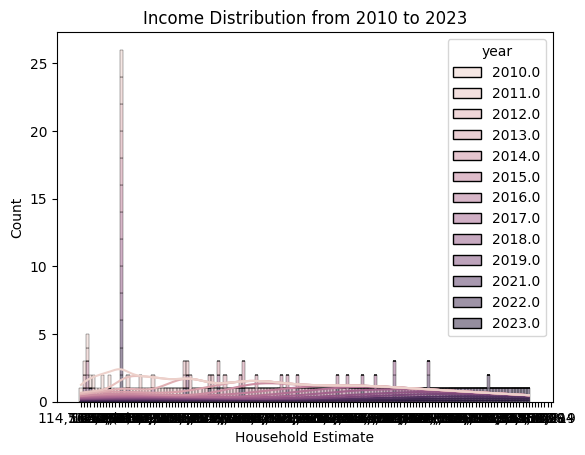

KeyError: 'label_grouping'

In [47]:
# Plot income distribution for each year
sns.histplot(data=all_data, x='households_estimate', hue='year', multiple='stack', kde=True)
plt.title('Income Distribution from 2010 to 2023')
plt.xlabel('Household Estimate')
plt.show()

# Line plot for a specific income bracket over time
income_bracket = '50,000-74,999'
subset = all_data[all_data['label_grouping'] == income_bracket]

sns.lineplot(x='year', y='households_estimate', data=subset)
plt.title(f'Trend of Households in {income_bracket} Bracket (2010-2023)')
plt.ylabel('Household Estimate')
plt.show()

# Notes
## Goals
viz using not matplot lib
show distributions over time
make a gif
statistically test those distributions over time

## Sources
Data source: https://data.census.gov/table?q=Income%20and%20Earnings&y=2020

api.census.gov/data/2023/acs/acs1?get=NAME,group(B01001)&for=us:1&key=2249a9e55442ff5573a8fa152b7e76ab6ecfd4d9
https://www.census.gov/data/developers/data-sets/acs-1year.html